<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_18/s18_mnist_conditional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts==0.2.5rc1
! pip install --quiet "torchinfo" "lightning-bolts"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 61.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pytorch-lightning-bolts==0.2.5rc1 (from versions: 0.1.0, 0.1.1, 0.2.0, 0.2.1, 0.2.2, 0.2.3, 0.2.4, 0.2.5, 0.3.0, 0.3.1, 0.3.2, 0.3.2.post0, 0.3.2.post1)
ERROR: No matching distribution found for pytorch-lightning-bolts==0.2.5rc1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 10.1 MB/s eta 0:00:00


In [2]:
# prerequisites
import random

import matplotlib.pyplot as pl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image

**Define VAE class**

In [3]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, num_labels=10, label_enc_dim=28):
        super(VAE, self).__init__()

        # label embedding
        self.label_enc_dim = label_enc_dim
        self.num_labels = num_labels
        self.class_embeddings = nn.Embedding(self.num_labels, self.label_enc_dim)

        # encoder part
        self.enc_inp_dim = x_dim+(self.num_labels*self.label_enc_dim)
        self.fc1 = nn.Linear(self.enc_inp_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.dec_inp_dim = z_dim + (self.num_labels*self.label_enc_dim)
        self.fc4 = nn.Linear(self.dec_inp_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)


    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)  # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)  # return z sample

    def decoder(self, z, label):
        label_enc = self.get_label_embedding(label)
        z = torch.cat([z, label_enc], dim=1)
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def get_label_embedding(self, label):
        label_one_hot = torch.nn.functional.one_hot(label, num_classes=10)
        label_enc = self.class_embeddings(label_one_hot)
        label_enc = torch.flatten(label_enc, start_dim=1)
        return label_enc

    def forward(self, x, label):
        x = x.view(-1, 784)
        label_enc = self.get_label_embedding(label)
        x = torch.cat([x, label_enc], dim=1)
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z, label), mu, log_var

**Define the Loss Function (Reconstruction Loss + KL Divergence Loss)**

In [4]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

**Define Train and Test methods**

In [5]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data, labels)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.cuda()
            labels = labels.cuda()
            recon, mu, log_var = vae(data, labels)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
            if epoch % 10 == 0:
                z = torch.randn(64, 2).cuda()
                this_label = 5 * torch.ones(64, dtype=torch.int64).cuda()
                sample = vae.decoder(z, this_label).cuda()
                save_image(sample.view(64, 1, 28, 28), f"./samples/sample_{epoch}.png")

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

**Show Image**

In [36]:
def show_image(img_tensor):
    #np_op_img = np.asarray(img_tensor.cpu()).squeeze()
    pl.figure()
    pl.imshow(img_tensor, cmap='gray')
    pl.colorbar()
    pl.show()

**Add the logic to generate conditional images. Here, we generate two images, one based on the input image and label and the other based on Input label. Finally, interpolate between the two samples.**

In [42]:
def conditional_generation(vae, test_loader, num_images=32, interp_weight=0.1):
    data, label = next(iter(test_loader))
    data = data.cuda()
    label = label.cuda()
    gen_images = []
    for cnt in range(num_images):
        x = data[cnt].view(-1, 784)
        l = label[cnt].unsqueeze(0)
        l_e = vae.get_label_embedding(l)
        x_l = torch.cat([x, l_e], dim=1)

        with torch.no_grad():
            # get mean and std of given image and label
            mu0, log_var0 = vae.encoder(x_l)
            z0 = vae.sampling(mu0, log_var0)

            # draw a random value of mean and std from standard gaussian
            shuffled_label_val = np.random.choice(np.arange(10, dtype=int))
            shuffled_label = torch.tensor(shuffled_label_val, dtype=torch.int64).unsqueeze(0).cuda()
            z1 = torch.randn(1, 2).cuda()

            z_interp = torch.lerp(z0, z1, weight=interp_weight)
            img_tensor = vae.decoder(z_interp, shuffled_label).view(1, 28, 28)
            gen_images.append(img_tensor)
    final_output = torch.vstack(gen_images)#.unsqueeze(1)
    print(final_output.shape)
    show_image(final_output.cpu().permute(1,2,0))
    #save_image(final_output, f'./samples/final_output_{weight*100}p.png')
    return final_output


**Run the training**

In [9]:
bs = 64
num_epochs=30
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=True)

# build model
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

# Define optimizer
optimizer = optim.Adam(vae.parameters())

for epoch in range(num_epochs):
    train(epoch)
    #test(epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 544.157959
Train Epoch: 0 [6400/60000 (11%)]	Loss: 183.009048
Train Epoch: 0 [12800/60000 (21%)]	Loss: 165.256317
Train Epoch: 0 [19200/60000 (32%)]	Loss: 161.788971
Train Epoch: 0 [25600/60000 (43%)]	Loss: 166.323334
Train Epoch: 0 [32000/60000 (53%)]	Loss: 166.779587
Train Epoch: 0 [38400/60000 (64%)]	Loss: 147.214432
Train Epoch: 0 [44800/60000 (75%)]	Loss: 143.506744
Train Epoch: 0 [51200/60000 (85%)]	Loss: 158.078873
Train Epoch: 0 [57600/60000 (96%)]	Loss: 145.276337
====> Epoch: 0 Average loss: 162.7415
Train Epoch: 1 [0/60000 (0%)]	Loss: 129.568542
Train Epoch: 1 [6400/60000 (11%)]	Loss: 139.881393
Train Epoch: 1 [12800/60000 (21%)]	Loss: 147.922821
Train Epoch: 1 [19200/60000 (32%)]	Loss: 142.019257
Train Epoch: 1 [25600/60000 (43%)]	Loss: 136.718048
Train Epoch: 1 [32000/60000 (53%)]	Loss: 131.878372
Train Epoch: 1 [38400/60000 (64%)]	Loss: 134.786469
Train Epoch: 1 [44800/60000 (75%)]	Loss: 136.731110
Train Epoch: 1 [51200/60000 (85%)]	Los

**Generate Images**

torch.Size([32, 28, 28])


TypeError: ignored

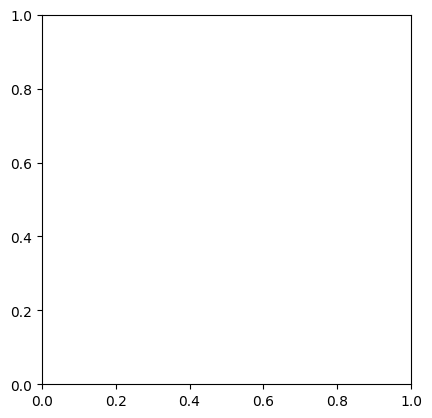

In [43]:
op = conditional_generation(vae, test_loader, num_images=32, interp_weight=0.5)